
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## Before running this notebook, you must have already the numerically simulated waves associated to the representative cases of synthetic simulated TCs (obtained with MaxDiss algorithm in notebook 06)

inputs required: 
  * Synthetic simulation of historical TCs parameters (copulas obtained in *notebook 06*)
  * MaxDiss selection of synthetic simulated TCs (parameters obtained in *notebook 06*)
  * simulated waves for the above selected TCs (**outside TeslaKit**)
  
in this notebook:
  * RBF's interpolation of wave conditions based on TCs parameters (from swan simulated TCs waves)

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import xarray as xr
import numpy as np

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..'))

# teslakit 
from teslakit.database import Database
from teslakit.rbf import RBF_Reconstruction, RBF_Validation



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/laurac/Dropbox/Majuro_training/teslakit/DATA'
db = Database(p_data)

# set site
db.SetSite('MAJURO-training')


In [10]:
# --------------------------------------
# load data and set parameters

# r2 TCs Copula Simulated (dataset) 
TCs_r2_sim_params = db.Load_TCs_r2_sim_params()

# r2 TCs MDA selection and solved simulations (not solved inside teslakit)
TCs_r2_MDA_params = db.Load_TCs_r2_mda_params()
TCs_sims = xr.open_dataset(db.paths.site.TCs.mda_r2_simulations_hytc)
TCs_sims=TCs_sims.rename({'Hs':'hs','Tp':'tp','Dir':'dir','Lel':'ss'})
TCs_sims.mu[np.where(TCs_sims.mu.values>1)[0]]=1

TCs_r2_MDA_params=TCs_r2_MDA_params.isel(storm=TCs_sims.storm.values)


## Simulated TCs -  Radial Basis Function

In [12]:
# --------------------------------------
# prepare dataset and subset

#  RBFs training subset (TCs numerically solved)
subset = np.column_stack(
    (TCs_r2_MDA_params['pressure_min'], TCs_r2_MDA_params['velocity_mean'], 
     TCs_r2_MDA_params['gamma'], TCs_r2_MDA_params['delta'])
)

#  RBFs dataset to interpolate 
dataset = np.column_stack(
    (TCs_r2_sim_params['pressure_min'], TCs_r2_sim_params['velocity_mean'], 
     TCs_r2_sim_params['gamma'], TCs_r2_sim_params['delta'])
)


In [13]:
# --------------------------------------
# Extract waves data from TCs simulations (this is the RBFs training target)

print(TCs_sims)
print()

# Normalize data
d_maxis = {}
d_minis = {}
tcp = TCs_sims.copy()
for k in ['hs', 'tp', 'ss', 'twl']:
    v = tcp[k].values[:]
    mx = np.nanmax(v)
    mn = np.nanmin(v)
    tcp[k] =(('storm',), (v-mn)/(mx-mn))
    
    # store maxs and mins for denormalization
    d_maxis[k] = mx
    d_minis[k] = mn

tcp['dir'] = tcp['dir'] #* np.pi/180
    
print(tcp)
print()


# Build RBF target numpy array
target = np.column_stack(
    (tcp['hs'], tcp['tp'], tcp['ss'], tcp['twl'], tcp['dir'], tcp['mu'])
)


<xarray.Dataset>
Dimensions:  (storm: 637)
Coordinates:
    point    int64 ...
    time     (storm) int32 ...
  * storm    (storm) int64 0 2 3 5 6 8 9 10 ... 983 985 988 990 991 995 997 999
Data variables:
    hs       (storm) float64 ...
    Tm       (storm) float64 ...
    tp       (storm) float64 ...
    dir      (storm) float64 ...
    ss       (storm) float64 ...
    X        (storm) float64 ...
    Y        (storm) float64 ...
    Z        (storm) float64 ...
    twl      (storm) float64 ...
    mu       (storm) float64 0.0 0.8521 0.8992 0.0 0.0 ... 0.8336 0.0 0.0 0.9157

<xarray.Dataset>
Dimensions:  (storm: 637)
Coordinates:
    point    int64 ...
    time     (storm) int32 ...
  * storm    (storm) int64 0 2 3 5 6 8 9 10 ... 983 985 988 990 991 995 997 999
Data variables:
    hs       (storm) float64 7.925e-05 0.1636 0.03686 ... 0.006146 0.1834
    Tm       (storm) float64 ...
    tp       (storm) float64 nan 0.4147 0.4027 nan ... 0.3985 nan 0.01515 0.5488
    dir      (storm) 

In [15]:
mask_nan=np.unique(np.where(np.isnan(target)==True)[0])
print('Nan cases = ' + str(len(mask_nan)))
target=np.delete(target,mask_nan, axis=0)
subset=np.delete(subset,mask_nan, axis=0)
np.shape(subset)

Nan cases = 121


(516, 4)

In [16]:
# --------------------------------------
# RBF Interpolation

# subset - scalar / directional indexes
ix_scalar_subset = [0,1]        # scalar (pmean,  vmean)
ix_directional_subset = [2,3]   # directional (delta, gamma)

# target - scalar / directional indexes
ix_scalar_target = [0,1,2,3,5]  # scalar (Hs, Tp, SS, TWL, MU)
ix_directional_target = [4]     # directional (Dir)

output = RBF_Reconstruction(
    subset, ix_scalar_subset, ix_directional_subset,
    target, ix_scalar_target, ix_directional_target,
    dataset)


ix_scalar: 0,  optimization: 11.75 | interpolation: 0.30
ix_scalar: 1,  optimization: 10.60 | interpolation: 0.31
ix_scalar: 2,  optimization: 12.45 | interpolation: 0.30
ix_scalar: 3,  optimization: 10.86 | interpolation: 0.29
ix_scalar: 5,  optimization: 14.62 | interpolation: 0.30
ix_directional: 4,  optimization: 22.12 | interpolation: 0.59


In [31]:
# --------------------------------------
# Reconstructed TCs

# denormalize RBF output
TCs_RBF_out = xr.Dataset(
    {
        'hs':(('storm',), output[:,0] * (d_maxis['hs']-d_minis['hs']) + d_minis['hs'] ),
        'tp':(('storm',), output[:,1] * (d_maxis['tp']-d_minis['tp']) + d_minis['tp'] ),
        'ss':(('storm',), output[:,2] * (d_maxis['ss']-d_minis['ss']) + d_minis['ss'] ),
        'twl':(('storm',), output[:,3] * (d_maxis['twl']-d_minis['twl']) + d_minis['twl'] ),
        'dir':(('storm',), output[:,4]),
        'mu':(('storm',), output[:,5]),
    },
    coords = {'storm': np.arange(output.shape[0])}
)
TCs_RBF_out['hs']=('storm', np.where(TCs_RBF_out.hs>0, TCs_RBF_out.hs, 0))
TCs_RBF_out['tp']=('storm', np.where(TCs_RBF_out.tp>0, TCs_RBF_out.tp, 0))

print(TCs_RBF_out)

# store data as xarray.Dataset
db.Save_TCs_sim_r2_rbf_output(TCs_RBF_out)

<xarray.Dataset>
Dimensions:  (storm: 8060)
Coordinates:
  * storm    (storm) int64 0 1 2 3 4 5 6 ... 8053 8054 8055 8056 8057 8058 8059
Data variables:
    hs       (storm) float64 0.2454 0.4267 1.231 1.538 ... 0.5556 1.063 0.7106
    tp       (storm) float64 3.85 3.627 7.925 8.027 ... 1.45 2.229 7.782 6.728
    ss       (storm) float64 -0.00538 0.01794 -0.01133 ... -0.006727 0.01234
    twl      (storm) float64 0.066 0.1094 0.4193 0.5577 ... 0.1976 0.3959 0.2172
    dir      (storm) float64 0.07176 134.4 29.8 15.97 ... 37.03 29.21 150.3
    mu       (storm) float64 0.6926 0.5757 0.8385 ... 0.6074 0.7487 0.9318


In [34]:
# --------------------------------------
# RBF Validation

# subset - scalar / directional indexes
ix_scalar_subset = [0,1]        # scalar (pmean,  vmean)
ix_directional_subset = [2,3]   # directional (delta, gamma)

# target - scalar / directional indexes
ix_scalar_target = [0,1,2,3,5]  # scalar (Hs, Tp, SS, TWL, MU)
ix_directional_target = [4]     # directional (Dir)

output = RBF_Validation(
    subset, ix_scalar_subset, ix_directional_subset,
    target, ix_scalar_target, ix_directional_target)


RBFs Kfold Validation: 1/3
ix_scalar: 0,  optimization: 4.91 | interpolation: 0.01
ix_scalar: 1,  optimization: 5.83 | interpolation: 0.01
ix_scalar: 2,  optimization: 4.58 | interpolation: 0.01
ix_scalar: 3,  optimization: 4.86 | interpolation: 0.01
ix_scalar: 5,  optimization: 5.91 | interpolation: 0.01
ix_directional: 4,  optimization: 10.76 | interpolation: 0.01
mean squared error : 2274.3360965063894

RBFs Kfold Validation: 2/3
ix_scalar: 0,  optimization: 4.23 | interpolation: 0.01
ix_scalar: 1,  optimization: 5.52 | interpolation: 0.01
ix_scalar: 2,  optimization: 5.23 | interpolation: 0.01
ix_scalar: 3,  optimization: 5.18 | interpolation: 0.01
ix_scalar: 5,  optimization: 7.48 | interpolation: 0.01
ix_directional: 4,  optimization: 11.66 | interpolation: 0.01
mean squared error : 1638.4544181366482

RBFs Kfold Validation: 3/3
ix_scalar: 0,  optimization: 4.08 | interpolation: 0.01
ix_scalar: 1,  optimization: 6.08 | interpolation: 0.01
ix_scalar: 2,  optimization: 6.62 | inter

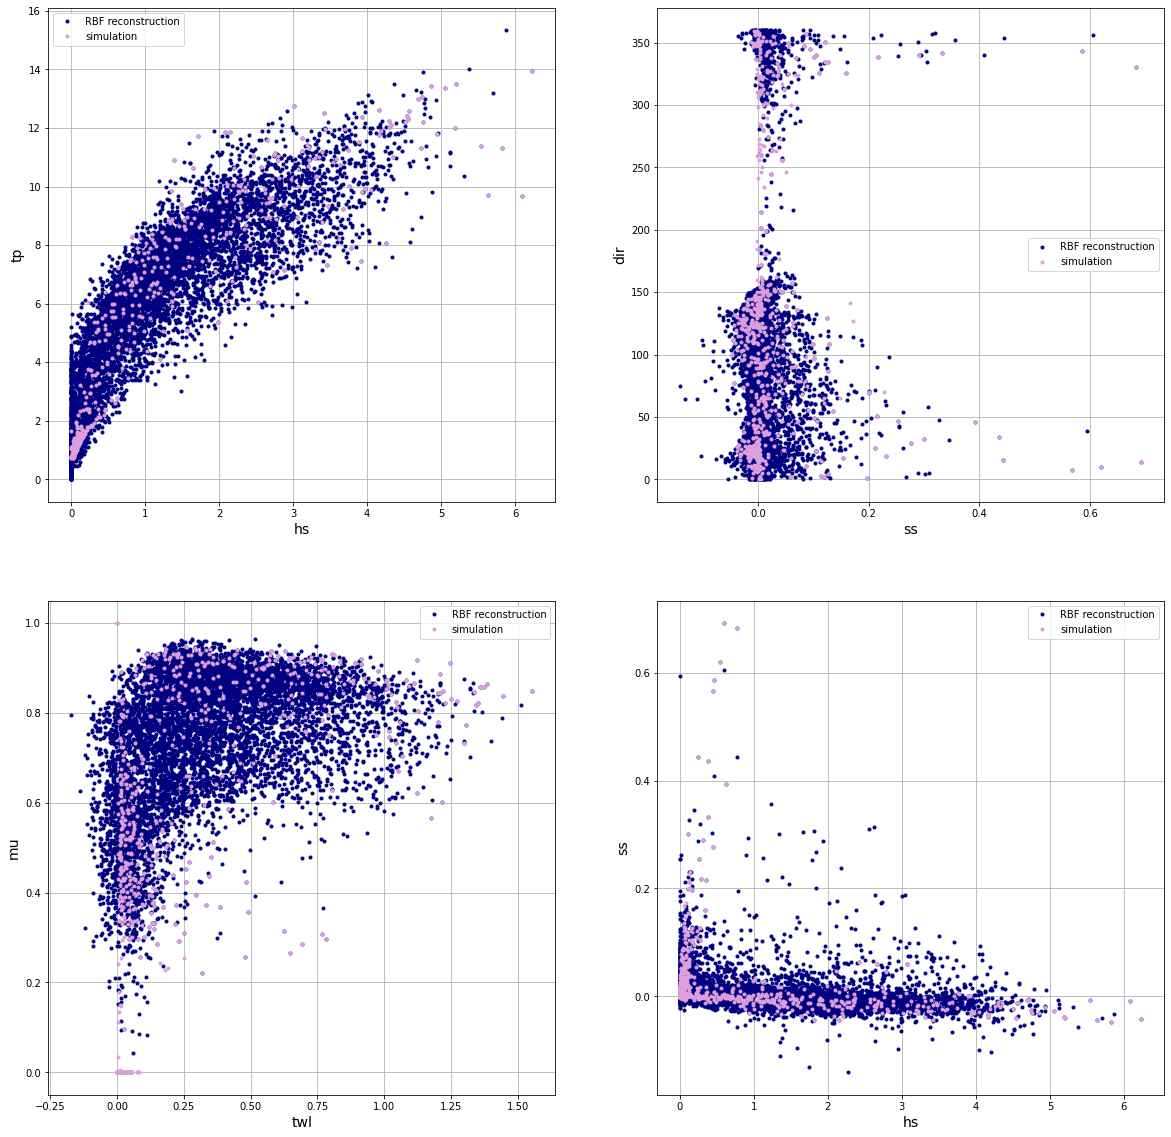

In [33]:
# PLOT

import matplotlib.pyplot as plt
from matplotlib import gridspec

var1 = 'hs'
var2 = 'tp'

fig=plt.figure(figsize=[20,20])
gs1=gridspec.GridSpec(2,2)
ax1=fig.add_subplot(gs1[0])
ax2=fig.add_subplot(gs1[1])
ax3=fig.add_subplot(gs1[2])
ax4=fig.add_subplot(gs1[3])

var1 = 'hs';  var2 = 'tp'
ax1.plot(TCs_RBF_out[var1].values[:], TCs_RBF_out[var2].values[:], '.',color='navy', label='RBF reconstruction')
ax1.plot(TCs_sims[var1].values[:], TCs_sims[var2].values[:], '.',color='plum', label='simulation')
ax1.set_xlabel(var1,fontsize=14)
ax1.set_ylabel(var2,fontsize=14)
ax1.legend()
ax1.grid()

var1 = 'ss';  var2 = 'dir'
ax2.plot(TCs_RBF_out[var1].values[:], TCs_RBF_out[var2].values[:], '.',color='navy', label='RBF reconstruction')
ax2.plot(TCs_sims[var1].values[:], TCs_sims[var2].values[:], '.',color='plum', label='simulation')
ax2.set_xlabel(var1,fontsize=14)
ax2.set_ylabel(var2,fontsize=14)
# ax2.set_ylim([0,360])
ax2.legend()
ax2.grid()

var1 = 'twl';  var2 = 'mu'
ax3.plot(TCs_RBF_out[var1].values[:], TCs_RBF_out[var2].values[:], '.',color='navy', label='RBF reconstruction')
ax3.plot(TCs_sims[var1].values[:], TCs_sims[var2].values[:], '.',color='plum', label='simulation')
ax3.set_xlabel(var1,fontsize=14)
ax3.set_ylabel(var2,fontsize=14)
ax3.legend()
ax3.grid()

var1 = 'hs';  var2 = 'ss'
ax4.plot(TCs_RBF_out[var1].values[:], TCs_RBF_out[var2].values[:], '.',color='navy', label='RBF reconstruction')
ax4.plot(TCs_sims[var1].values[:], TCs_sims[var2].values[:], '.',color='plum', label='simulation')
ax4.set_xlabel(var1,fontsize=14)
ax4.set_ylabel(var2,fontsize=14)
ax4.legend()
ax4.grid()